Avec les mêmes données des post Python et R nous allons entrainer deux modèles des réseau de neurones
avec Keras et TensorFlow

# importation du dataset et conversion

In [61]:
import numpy as np
import pandas as pd

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str',
                    'Tags': 'str','Text_raw':'str'}

nrows = 20000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )


text_train, tag_train = df_questions.Text_raw, df_questions.Tags

Nous obtenons un boost de performance en utilisant le `texte brut` sans prétraitement passant d'un
f1 score de 82.6 %  à un f1 Score de 83.4 %, nous allons garder par la suite le texte sans prétraitement

In [62]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Nous créons un tokenizer, configuré pour ne prendre
# en compte que les 10000 mots les plus courants pour
# le texte et 100 pour les tags

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=33)  # 33 tags limite pour un modèle à deux layers sans embedding

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_matrix(text_train, mode='binary')
Y_train = tokenizer_Y.texts_to_matrix(tag_train, mode='binary')

X_train_padded = pad_sequences(X_train, padding="post")
Y_train_padded = pad_sequences(Y_train, padding="post")

label_len=len(Y_train_padded[0])

# Les posts ont été randomisés dans le prétraitement, nous utilisons les premiers 1000 post
# comme Validation et les suivants 1000 comme notre test set le restant de notre dataset
# sera utilisé pour entrainement du modèle

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

# Nous créons deux dictionnaires avec tous les mots trouvés dans le datasets et pas seulement
# ceux utilisés pour vectoriser les datas, nous avons donc  61769 mots pour les posts et
# 2966 mots pour les tags. Nous créons aussi un dictionnaire inversée que va nous servir pour
# traduire les prédictions du modèle

word_index_X = tokenizer_X.word_index
word_index_Y = tokenizer_Y.word_index

reverse_word_index_Y = dict (
    [(value,key) for (key,value) in word_index_Y.items()]
)
print('Found %s unique tokens in the posts.' % len(word_index_X))
print('Found %s unique tokens in the tags.' % len(word_index_Y))

Found 61769 unique tokens in the posts.
Found 2966 unique tokens in the tags.


In [63]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

Le modèle choisi est composé de deux couches denses avec 100 unité chacun qui semblé
être bien adapté pour liste de 32 tags, lors du passage à 100 tags
le réseux n'est plus capable d'apprendre plus de deux tags, nous avons
donc augmenté le nombre d'unités des deux premières couches allant jusqu'à 5000 unités
et nous avons aussi essayé d'aumenter le nombre de couches sans succès

In [64]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

In [66]:

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val, Y_val))
model.summary()

Epoch 1/30
24/24 [==============================] - 1s 15ms/step - loss: 0.3365 - acc: 0.5964 - f1_m: 0.4633 - precision_m: 0.5374 - recall_m: 0.4892 - val_loss: 0.1422 - val_acc: 0.7460 - val_f1_m: 0.5686 - val_precision_m: 0.7463 - val_recall_m: 0.4593
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1292 - acc: 0.7233 - f1_m: 0.5500 - precision_m: 0.7240 - recall_m: 0.4435 - val_loss: 0.1166 - val_acc: 0.7470 - val_f1_m: 0.5719 - val_precision_m: 0.7479 - val_recall_m: 0.4629

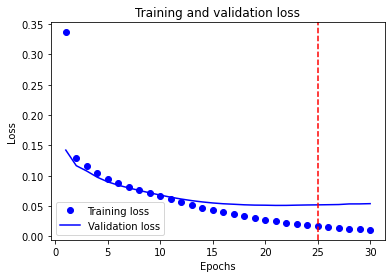

In [67]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=25,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

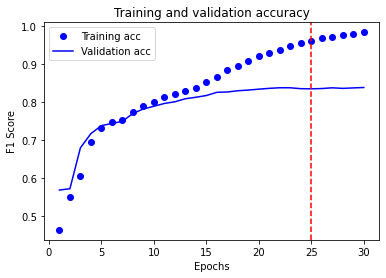

In [68]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=25,color='red',linestyle='--')

plt.show()

In [69]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.05516139417886734
Accuracy :  0.9670000076293945
f1 Score :  0.8378771543502808
precision :  0.9297096133232117
recall :  0.7650997638702393


In [70]:
Y_predict = model.predict(X_train_padded)

In [71]:
Y_predict_ones = (Y_predict>0.5).astype(int)
np.sum(Y_predict_ones,axis=0)

array([    0, 10072,  3941,   822,   630,   498,   510,   413,   364,
         334,   357,   276,   272,   243,   274,   233,   196,   228,
         191,   167,   178,   195,   175,   144,    77,   141,   103,
         141,    80,   109,   113,   118,   133])

In [72]:
# On re entraine le modèle du début pour 25 epoch
model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )
model.summary()

Epoch 1/25
24/24 [==============================] - 1s 15ms/step - loss: 0.3141 - acc: 0.6464 - f1_m: 0.4698 - precision_m: 0.5704 - recall_m: 0.4537 - val_loss: 0.1372 - val_acc: 0.7460 - val_f1_m: 0.5692 - val_precision_m: 0.7466 - val_recall_m: 0.4599
Epoch 2/25
24/24 [==============================] - 0s 8ms/step - loss: 0.1250 - acc: 0.7405 - f1_m: 0.5626 - precision_m: 0.7457 - recall_m: 0.4518 - val_loss: 0.1129 - val_acc: 0.8140 - val_f1_m: 0.6177 - val_precision_m: 0.8149 - val_recall_m: 0.4974

In [73]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.05343744531273842
Accuracy :  0.9580000042915344
f1 Score :  0.8319741487503052
precision :  0.93179851770401
recall :  0.753491997718811


In [74]:
Y_predict = model.predict(X_train_padded)

In [75]:
def vector_to_list_of_tags(vect_tag,reverse_word_ind):
    tag_list=[]
    for i in range(len(vect_tag)):
        if vect_tag[i]>0 :
            tag_list.append(reverse_word_ind.get(i,'?'))
    return tag_list

In [76]:
id_sample = 6

print('reverse word index Y : ',reverse_word_index_Y)
print('Tags before vectoring : ',tag_train[id_sample])
print('Tags vectorize matrix : ',Y_train_padded[id_sample])

sample_tag = vector_to_list_of_tags(Y_train_padded[id_sample],reverse_word_index_Y)
print('Tags vectorized : ',sample_tag)

Y_predict_ones = (Y_predict>0.5).astype(int)
sample_tag_pred = vector_to_list_of_tags(Y_predict_ones[id_sample],reverse_word_index_Y)
print('Tags predicted matrix: ',np.around(Y_predict[id_sample], decimals=1))
print('Tags predicted : ',sample_tag_pred)

reverse word index Y :  {1: 'python', 2: 'r', 3: 'django', 4: 'ggplot2', 5: 'list', 6: 'numpy', 7: 'string', 8: 'dataframe', 9: 'x', 10: 'matplotlib', 11: '3', 12: '2', 13: 'data', 14: 'dictionary', 15: 'regex', 16: 'file', 17: 'pandas', 18: 'plot', 19: '7', 20: 'table', 21: 'dplyr', 22: 'datetime', 23: 'testing', 24: 'faq', 25: 'flask', 26: 'class', 27: 'sqlalchemy', 28: 'function', 29: 'c', 30: 'import', 31: 'performance', 32: 'models', 33: 'windows', 34: 'scipy', 35: 'exception', 36: 'arrays', 37: 'unicode', 38: 'unit', 39: 'csv', 40: 'markdown', 41: 'date', 42: 'sorting', 43: 'matrix', 44: 'variables', 45: 'shiny', 46: 'io', 47: 'linux', 48: 'json', 49: 'time', 50: 'multithreading', 51: 'module', 52: 'knitr', 53: 'image', 54: 'tkinter', 55: 'mysql', 56: 'memory', 57: 'formatting', 58: 'pip', 59: 'statistics', 60: 'oop', 61: 'rstudio', 62: 'package', 63: 'processing', 64: 'syntax', 65: 'algorithm', 66: 'virtualenv', 67: 'logging', 68: 'google', 69: 'line', 70: 'parsing', 71: 'random

In [77]:
np.sum(Y_predict_ones,axis=0)

array([    0, 10066,  3934,   823,   628,   501,   497,   387,   349,
         288,   356,   243,   250,   186,   254,   218,   123,   227,
         170,   129,   166,   186,   168,   136,    13,   143,    46,
         142,    10,   107,    81,    83,    53])

# Embedding

In [78]:
from keras.layers import Embedding, Flatten

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=100)  # 100 tags posible avec embedding avec des résultats corrects

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_sequences(text_train)
Y_train = tokenizer_Y.texts_to_matrix(tag_train,mode='binary')

X_train_padded = pad_sequences(X_train, padding="post",maxlen=1000)
Y_train_padded = pad_sequences(Y_train, padding="post")

#X_train_padded = X_train_padded/len(word_index_X) #normalisation

text_len = len(X_train_padded[0])
label_len=len(Y_train_padded[0])

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

In [79]:

model = models.Sequential()
model.add(Embedding(10000, 100, input_length=text_len))
# our activations have shape `(samples, text_len, 20)`.
# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, text_len * 100)`
model.add(Flatten())
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/15
24/24 [==============================] - 1s 35ms/step - loss: 0.1256 - acc: 0.6927 - f1_m: 0.4546 - precision_m: 0.6860 - recall_m: 0.3636 - val_loss: 0.0770 - val_acc: 0.7460 - val_f1_m: 0.4849 - val_precision_m: 0.7463 - val_recall_m: 0.3591

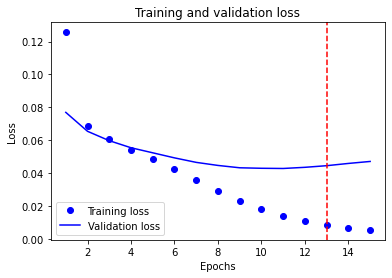

In [80]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=13,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

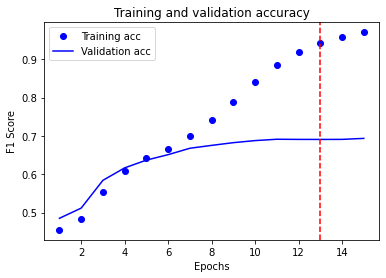

In [81]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=13,color='red',linestyle='--')

plt.show()

Nous observons un fort overfiting du modèle, nous allons ajouter
des couches dropout pour régulariser le modèle

In [82]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.043927986174821854
Accuracy :  0.9750000238418579
f1 Score :  0.7126989960670471
precision :  0.9666005969047546
recall :  0.566108226776123


In [83]:

model = models.Sequential()
model.add(Embedding(10000, 100, input_length=text_len))
model.add(Flatten())
model.add(layers.Dropout(0.5))
# ajout de la régularisation par Dropout des 50% des unités
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/15
24/24 [==============================] - 2s 52ms/step - loss: 0.1263 - acc: 0.6814 - f1_m: 0.4466 - precision_m: 0.6802 - recall_m: 0.3523 - val_loss: 0.0771 - val_acc: 0.7460 - val_f1_m: 0.4849 - val_precision_m: 0.7463 - val_recall_m: 0.3591

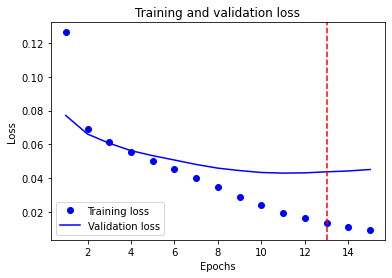

In [84]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=13,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

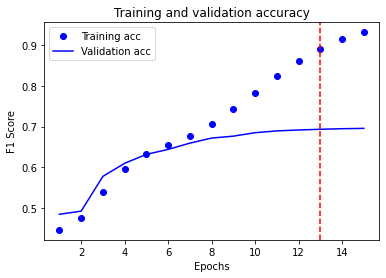

In [85]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=13,color='red',linestyle='--')

plt.show()

Nous n'observons plus un fort overfiting du modèle, après l'ajout
des couches dropout pour régulariser le modèle

In [86]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.04172784835100174
Accuracy :  0.9710000157356262
f1 Score :  0.7126182913780212
precision :  0.9686492085456848
recall :  0.5651829242706299


In [87]:
# On re entraine le modèle du début pour 15 epoch
model = models.Sequential()
model.add(Embedding(10000, 100, input_length=text_len))
# our activations have shape `(samples, text_len, 20)`.

# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=13,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )
model.summary()

Epoch 1/13
24/24 [==============================] - 1s 35ms/step - loss: 0.1256 - acc: 0.6920 - f1_m: 0.4547 - precision_m: 0.6891 - recall_m: 0.3576 - val_loss: 0.0773 - val_acc: 0.7460 - val_f1_m: 0.4849 - val_precision_m: 0.7463 - val_recall_m: 0.3591

In [88]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.04157043248414993
Accuracy :  0.9679999947547913
f1 Score :  0.7082464694976807
precision :  0.9628224968910217
recall :  0.5621196627616882


In [89]:
embedd_predict = model.predict(partial_X_train)
embedd_predict_ones = (embedd_predict>0.5).astype(int)

In [90]:
np.sum(embedd_predict_ones,axis=0)

array([   0, 8619, 3360,  712,  535,  429,  425,  323,  322,  227,  283,
        202,  197,  216,  209,  188,  151,  196,  170,  135,  173,  168,
        149,  121,  109,  114,  108,  118,   96,   98,  115,   99,  113,
         99,  104,   88,   91,   87,   95,   96,   96,   87,   85,   91,
         70,   86,   76,   66,   81,   64,   59,   74,   85,   68,   68,
         66,   69,   60,   69,   56,   58,   73,   69,   67,   39,   58,
         70,   64,   57,   52,   60,   52,   53,   54,   58,   50,   51,
         60,   41,   44,   42,   55,   53,   46,   48,   38,   39,   53,
         36,   47,   40,   42,   43,   37,   38,   50,   46,   35,   47,
         31])

In [91]:
np.sum(partial_Y_train,axis=0)

array([   0, 8617, 3372,  731,  547,  466,  449,  390,  338,  318,  298,
        273,  285,  264,  243,  223,  201,  209,  202,  193,  177,  180,
        168,  134,  148,  130,  134,  130,  130,  122,  133,  137,  124,
        118,  120,  111,  118,  113,  106,  105,   99,  102,  106,  103,
         97,   90,   93,   93,   94,   90,   78,   91,   87,   79,   83,
         80,   81,   83,   81,   75,   77,   80,   83,   82,   67,   75,
         77,   75,   72,   69,   74,   76,   67,   63,   70,   56,   64,
         69,   65,   65,   57,   62,   58,   58,   59,   55,   51,   56,
         56,   62,   58,   58,   52,   48,   54,   57,   57,   51,   56,
         45])

# Utilisation d'un embedding pré entrainé Glove

In [92]:
import os
# fichier téléchargé de https://nlp.stanford.edu/projects/glove/
glove_dir = 'embedding/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [93]:
max_words = 10000
embedding_dim = 100 # dimension du embedding importé glove.6B.50d.txt

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index_X.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [94]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(10000, embedding_dim, input_length=text_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(label_len, activation='sigmoid'))
model.summary()

# charger l'embedding entrainé
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])


history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.save_weights('pre_trained_glove_model.h5')


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 100000)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                3200032   
_________________________________________________________________
dense_28 (Dense)             (None, 100)               3300      
Total params: 4,203,332
Trainable params: 4,203,332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
24/24 [==============================] - 1s 26ms/step - loss: 0.5458 - acc: 0.0073 - f1_m: 0.0714 - precision_m: 0.0387 - recall_m: 0.5060 - val_loss: 0.3545 - val_acc: 0.0040 - val_f1_m: 0.1100 - val_precision_m: 0.0630 - val_rec

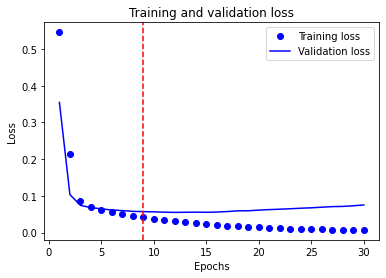

In [95]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=9,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

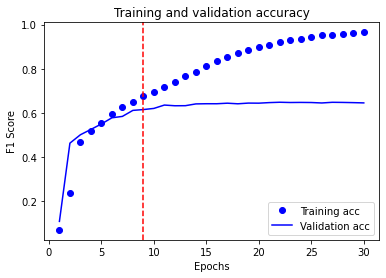

In [96]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=9,color='red',linestyle='--')

plt.show()

In [97]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.07476181536912918
Accuracy :  0.9409999847412109
f1 Score :  0.6593791246414185
precision :  0.9015674591064453
recall :  0.5216262936592102
